In [ ]:
# Part 1: Import Required Libraries


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, roc_curve
)

import pickle
import warnings
warnings.filterwarnings("ignore")

# NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Dataset Shape: (3728, 2)

Missing Values:
 essay    0
label    0
dtype: int64

Label Counts:
 label
0    1864
1    1864
Name: count, dtype: int64


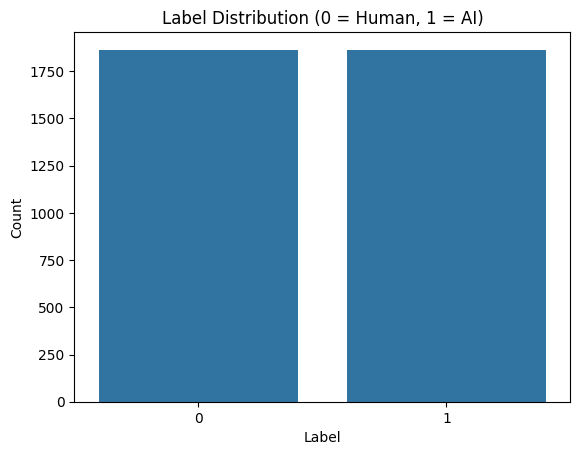

In [ ]:
# Part 2: Load and Explore Dataset


df = pd.read_excel("AI_vs_human_train_dataset.xlsx")
df.head()

#  Basic Info & Visualization

print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print("\nLabel Counts:\n", df['label'].value_counts())

# Visualize label distribution
sns.countplot(x='label', data=df)
plt.title("Label Distribution (0 = Human, 1 = AI)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [ ]:


#  3. Text Preprocessing

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.tokenizer = RegexpTokenizer(r'\w+')

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)
        tokens = self.tokenizer.tokenize(text)
        tokens = [t for t in tokens if t not in self.stop_words]
        tokens = [self.lemmatizer.lemmatize(t) for t in tokens]
        return ' '.join(tokens)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.apply(self.clean_text)

# Clean text column
df['clean_text'] = TextPreprocessor().fit_transform(df['essay'])

# Split Data
X = df['clean_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

# Save directly to your existing folders
train_df.to_csv("data/training_data/train.csv", index=False)
test_df.to_csv("data/test_data/test.csv", index=False)

print("Train and test data saved to 'data/training_data/' and 'data/test_data/'")


Train and test data saved to 'data/training_data/' and 'data/test_data/'


In [ ]:
# Models and Pipelining

# Model Pipelines & Grid Search

import time
print("Starting GridSearchCV for SVM...")
start = time.time()

svm_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', SVC(probability=True))
])

svm_params = {
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'vectorizer__max_features': [1000, 3000],
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf']
}

svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=3, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)

end = time.time()
print("Finished SVM GridSearchCV in {:.2f} seconds".format(end - start))
print("Best Parameters:", svm_grid.best_params_)


# Model Pipelines and Desison tree

print("\nStarting GridSearchCV for Decision Tree...")

dt_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

dt_params = {
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10]
}

dt_grid = GridSearchCV(dt_pipeline, dt_params, cv=3, scoring='accuracy', n_jobs=-1)
dt_grid.fit(X_train, y_train)

print("Decision Tree GridSearchCV Completed")
print("Best Parameters:", dt_grid.best_params_)

# Model Pipelines and AdaBoost

print("\n Running GridSearchCV for AdaBoost...")

ab_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', AdaBoostClassifier(random_state=42))
])

ab_params = {
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'classifier__n_estimators': [50, 100, 150]
}

ab_grid = GridSearchCV(ab_pipeline, ab_params, cv=3, scoring='accuracy', n_jobs=-1)
ab_grid.fit(X_train, y_train)

print("AdaBoost GridSearchCV Done")
print("Best Parameters:", ab_grid.best_params_)

Starting GridSearchCV for SVM...
Finished SVM GridSearchCV in 997.22 seconds
Best Parameters: {'classifier__C': 1, 'classifier__kernel': 'linear', 'vectorizer__max_features': 3000, 'vectorizer__ngram_range': (1, 1)}

Starting GridSearchCV for Decision Tree...
Decision Tree GridSearchCV Completed
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'vectorizer__ngram_range': (1, 1)}

 Running GridSearchCV for AdaBoost...
AdaBoost GridSearchCV Done
Best Parameters: {'classifier__n_estimators': 150, 'vectorizer__ngram_range': (1, 1)}


SVM Evaluation:
Accuracy: 0.9651474530831099
F1 Score: 0.9651474530831099
ROC AUC: 0.9959174578987845


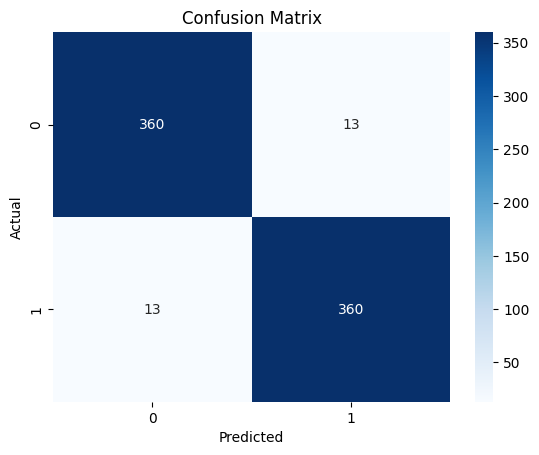

Decision Tree Evaluation:
Accuracy: 0.8458445040214477
F1 Score: 0.8426812585499316
ROC AUC: 0.8447987119867173


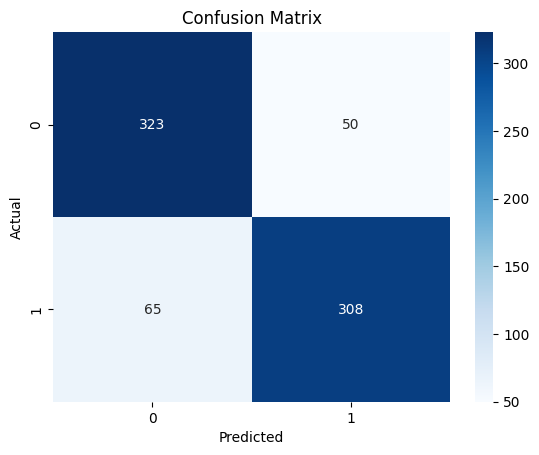

AdaBoost Evaluation:
Accuracy: 0.9504021447721179
F1 Score: 0.9504685408299867
ROC AUC: 0.9888520725369979


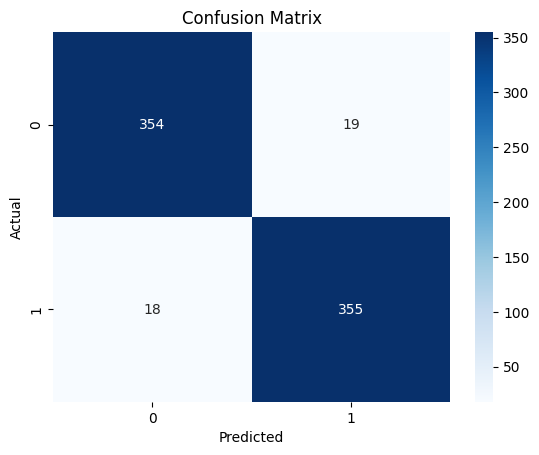

In [ ]:
# Evalauting the function

def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Evalauation of the models

print("SVM Evaluation:")
evaluate(svm_grid.best_estimator_, X_test, y_test)

print("Decision Tree Evaluation:")
evaluate(dt_grid.best_estimator_, X_test, y_test)

print("AdaBoost Evaluation:")
evaluate(ab_grid.best_estimator_, X_test, y_test)

In [ ]:
# Saving the models
import os

print("Saving all trained models")

with open("models/svm_model.pkl", "wb") as f:
    pickle.dump(svm_grid.best_estimator_, f)
    print("SVM Model Saved")

with open("models/decision_tree_model.pkl", "wb") as f:
    pickle.dump(dt_grid.best_estimator_, f)
    print("Decision Tree Model Saved")

with open("models/adaboost_model.pkl", "wb") as f:
    pickle.dump(ab_grid.best_estimator_, f)
    print("AdaBoost Model Saved")

with open("models/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(svm_grid.best_estimator_.named_steps['vectorizer'], f)
    print("TF-IDF Vectorizer Saved")




Saving all trained models
SVM Model Saved
Decision Tree Model Saved
AdaBoost Model Saved
TF-IDF Vectorizer Saved
